# Miscellaneous

In [1]:
# | default_exp misc

In [2]:
# | export
import time
from torch_snippets.logger import Debug, Warn, debug_mode, Info, Trace, trace_mode
from torch_snippets.markup2 import AD
from functools import wraps
from fastcore.basics import ifnone
from fastcore.foundation import L

In [ ]:
# | export
# | hide


class Timer:
    def __init__(self, N, smooth=True, mode=1):
        "print elapsed time every iteration and print out remaining time"
        "assumes this timer is called exactly N times or less"
        self.tok = self.start = time.time()
        self.N = N
        assert N is None or N >= 0, "N should be None or a non-negative integer"
        self.ix = 0
        self.smooth = smooth
        self.mode = mode
        # 0 = instant-speed, i.e., time remaining is a funciton of only the last iteration
        # Useful when you know that each loop takes unequal time (increasing/decreasing speeds)
        # 1 = average, i.e., time remaining is a function of average of all iterations
        # Usefule when you know on average each loop or a group of loops take around the same time

    def __call__(self, *, ix=None, info=None):
        ix = self.ix if ix is None else ix
        info = "" if info is None else f"{info}\t"
        tik = time.time()
        elapsed = tik - self.start

        _total = self.N if self.N is not None else "*"

        if self.mode == 0:
            ielapsed = tik - self.tok
            ispeed = ielapsed
            if self.N is not None:
                iremaining = (self.N - (ix + 1)) * ispeed
            else:
                iremaining = -1

            iunit = "s/iter"
            if ispeed < 1:
                ispeed = 1 / ispeed
                iunit = "iters/s"

            iestimate = iremaining + elapsed
            _remaining = f"- {iremaining:.2f}s remaining " if self.N is not None else ""

            _info = f"{info}{ix+1}/{_total} ({elapsed:.2f}s {_remaining}- {ispeed:.2f} {iunit})"

        else:
            speed = elapsed / (ix + 1)
            if self.N is not None:
                remaining = (self.N - (ix + 1)) * speed
            else:
                remaining = -1

            unit = "s/iter"
            if speed < 1:
                speed = 1 / speed
                unit = "iters/s"
            estimate = remaining + elapsed
            _remaining = f" - {remaining:.2f}s remaining " if self.N is not None else ""
            _info = f"{info}{ix+1}/{_total} ({elapsed:.2f}s {_remaining}- {speed:.2f} {unit})"

        print(
            _info + " " * 10,
            end="\r",
        )
        self.ix += 1
        self.tok = tik


def track2(iterable, *, total=None, info_prefix=None):
    info_prefix = ifnone(info_prefix, "")
    try:
        total = ifnone(total, len(iterable))
    except Exception as e:
        Warn(f"Unable to get length of iterable: {e}")
    timer = Timer(total)
    for item in iterable:
        info = yield item
        _info = f"{info_prefix} {info}" if info_prefix else info
        timer(info=_info)
        if info is not None:
            yield  # Just to ensure the send operation stops


## Timer
Use timer as a standalone class so you have full control on when to call a lap (most useful in while loops)...

In [4]:
N = 50
t = Timer(N)
info = None

for i in range(N):
    time.sleep(0.01)
    t(info=info)  # Lap and present the time
    if i == N // 2:
        print()
        info = f"My Info: {i*3.122}"

26/50 (0.32s - 0.30s remaining - 80.72 iters/s)          


## Track2
... or use track2 to directly track a for loop

In [5]:
N = 50
info = None

for i in (tracker := track2(range(N), total=N)):
    time.sleep(0.01)
    info = f"My Info: {i*3.122:.2f}"
    if i == N // 2:
        print()
    if i >= N // 2:
        tracker.send(info)

25/50 (0.30s - 0.30s remaining - 83.74 iters/s)          


Warning! NEVER RUN `tracker.send(None)` as this will skip variables silently

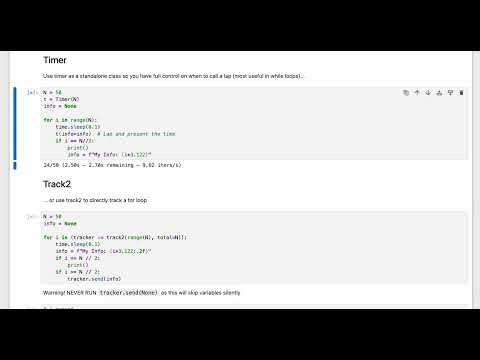

In [6]:
# | echo: false
from IPython.display import YouTubeVideo

# Replace 'video_id' with the actual YouTube video ID
YouTubeVideo("XcU-a-eksMA", width=560, height=315)

In [7]:
# | export
# | hide


def summarize_input(args, kwargs, outputs=None):
    o = AD(args, kwargs)
    if outputs is not None:
        o.outputs = outputs
    return o.summary()


def timeit(func):
    def inner(*args, **kwargs):
        s = time.time()
        o = func(*args, **kwargs)
        Info(f"{time.time() - s:.2f} seconds to execute `{func.__name__}`")
        return o

    return inner


def io(func=None, *, level="debug"):
    logfuncs = {
        "debug": lambda i: Debug(i, depth=2),
        "info": lambda i: Info(i, depth=2),
        "trace": lambda i: Trace(i, depth=2),
    }
    try:
        logfunc = logfuncs[level.lower()]
    except KeyError:
        raise ValueError(f"level should be one of {list(logfuncs.keys())}")

    def decorator(func):
        def inner(*args, **kwargs):
            if level == "trace":
                try:
                    from pysnooper import snoop
                except ModuleNotFoundError:
                    raise ModuleNotFoundError(
                        "`pip install pysnooper` if you want to trace the function line by line"
                    )
                _func = snoop()(func)
            else:
                _func = func
            s = time.time()
            o = _func(*args, **kwargs)
            info = f"""
{time.time() - s:.2f} seconds to execute `{func.__name__}`
{summarize_input(args=args, kwargs=kwargs, outputs=o)}
            """
            logfunc(info)
            return o

        return inner

    if func is None:
        o = decorator
    else:
        o = decorator(func)
    return o

## Print execution time
`@timeit` decorates and prints time taken to execute a function as an info log

In [8]:
@timeit
def foo(a, b=None):
    if b is None:
        return a + 1
    else:
        time.sleep(2)
        return a + b

In [9]:
foo(10)
foo(10, b=20)

[09/08/24 21:15:23] INFO     0.00 seconds to execute `foo`                                                                                            ]8;id=173016;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3546464892.py:16\3546464892.py]8;;\:]8;id=189927;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3546464892.py:16#inner:16\inner:16]8;;\

[09/08/24 21:15:25] INFO     2.01 seconds to execute `foo`                                                                                            ]8;id=632274;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3546464892.py:16\3546464892.py]8;;\:]8;id=554827;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3546464892.py:16#inner:16\inner:16]8;;\

30

## Print IO
`@io` will decorate to show inputs and outputs (along with time taken to execute) as a debug log

In [10]:
@io
def foo(a, b=None):
    if b is None:
        return a + 1
    else:
        time.sleep(2)
        return a + b


with debug_mode():
    foo(10)
    foo(10, b=20)

[09/08/24 21:15:26] DEBUG                                                                                                                          ]8;id=551079;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3679299354.py:11\3679299354.py]8;;\:]8;id=466235;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3679299354.py:11#<module>:11\<module>:11]8;;\
                             0.00 seconds to execute `foo`                                                                                                                  
                             args()                                                                                                                                         
                               0 - 10 (🏷️ int)                                                                                                                               
                             kwargs                                                                                                                                         
                             outputs - 11 (🏷️ int)                                                                                                                           
                                                                                                                                                                            
                                                                                                                                                                            

[09/08/24 21:15:28] DEBUG                                                                                                                          ]8;id=719917;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3679299354.py:12\3679299354.py]8;;\:]8;id=466682;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3679299354.py:12#<module>:12\<module>:12]8;;\
                             2.01 seconds to execute `foo`                                                                                                                  
                             args()                                                                                                                                         
                               0 - 10 (🏷️ int)                                                                                                                               
                             kwargs                                                                                                                                         
                               b - 20 (🏷️ int)                                                                                                                               
                             outputs - 30 (🏷️ int)                                                                                                                           
                                                                                                                                                                            
                                                                                                                                                                            

`@io` can be forced to print as log/trace if needed

In [11]:
@io(level="trace")
def foo(a, b=None):
    if b is None:
        return a + 1
    else:
        time.sleep(2)
        return a + b


with trace_mode():
    foo(10)
    import time

    time.sleep(1)
    foo(10, b=20)

Source path:... /var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3366644769.py
Starting var:.. a = 10
Starting var:.. b = None
21:15:28.086121 call         2 def foo(a, b=None):
21:15:28.086353 line         3     if b is None:
21:15:28.086394 line         4         return a + 1
21:15:28.086413 return       4         return a + 1
Return value:.. 11
Elapsed time: 00:00:00.000727


[09/08/24 21:15:28] TRACE                                                                                                                          ]8;id=905678;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3366644769.py:11\3366644769.py]8;;\:]8;id=886845;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3366644769.py:11#<module>:11\<module>:11]8;;\
                             0.00 seconds to execute `foo`                                                                                                                  
                             args()                                                                                                                                         
                               0 - 10 (🏷️ int)                                                                                                                               
                             kwargs                                                                                                                                         
                             outputs - 11 (🏷️ int)                                                                                                                           
                                                                                                                                                                            
                                                                                                                                                                            

Source path:... /var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3366644769.py
Starting var:.. a = 10
Starting var:.. b = 20
21:15:29.096196 call         2 def foo(a, b=None):
21:15:29.096974 line         3     if b is None:
21:15:29.097093 line         6         time.sleep(2)
21:15:31.097930 line         7         return a + b
21:15:31.098743 return       7         return a + b
Return value:.. 30
Elapsed time: 00:00:02.003559


[09/08/24 21:15:31] TRACE                                                                                                                          ]8;id=400373;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3366644769.py:15\3366644769.py]8;;\:]8;id=169817;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/3366644769.py:15#<module>:15\<module>:15]8;;\
                             2.00 seconds to execute `foo`                                                                                                                  
                             args()                                                                                                                                         
                               0 - 10 (🏷️ int)                                                                                                                               
                             kwargs                                                                                                                                         
                               b - 20 (🏷️ int)                                                                                                                               
                             outputs - 30 (🏷️ int)                                                                                                                           
                                                                                                                                                                            
                                                                                                                                                                            

In [ ]:
# | export
# | hide


def tryy(
    func=None,
    *,
    output_to_return_on_fail=None,
    silence_errors=False,
    print_traceback=False,
    store_errors: bool = True,
):
    def decorator(f):
        if isinstance(store_errors, bool) and store_errors:
            error_store = []
        elif isinstance(store_errors, (list, type([]))):  # Avoid `L` unless defined
            error_store = store_errors

        @wraps(f)  # Preserve the original function's metadata
        def wrapper(*args, **kwargs):
            try:
                return f(*args, **kwargs)
            except Exception as e:
                if not silence_errors:
                    if not print_traceback:
                        tb = f"{type(e).__name__}: {str(e)}"
                        Warn(f"Error for `{f.__name__}`: {tb}")
                    else:
                        import traceback

                        tb = traceback.format_exc()
                        Warn(f"Error for `{f.__name__}`:\n{tb}")
                else:
                    tb = None
                if store_errors is not None:
                    error_store.append(
                        {
                            "func": f.__name__,
                            "args": args,
                            "kwargs": kwargs,
                            "tb": tb,
                            "err_type": type(e).__name__,
                        }
                    )
                return output_to_return_on_fail

        # Attach additional attributes
        wrapper.F = f
        wrapper.error_store = error_store

        def errors():
            import pandas as pd

            return pd.DataFrame(error_store)

        wrapper.errors = errors
        wrapper.error_summary = errors  # backward compatibility
        return wrapper

    if callable(func):
        return decorator(func)
    return decorator

## Try Catch with a single line

In [13]:
@tryy
def do(a, b, c):
    return 1 / 0


x = do(1, 2, c=10)
assert x is None  # tryy returns None by default

[09/08/24 21:15:31] WARNING  Error for `do` with                                                                                                      ]8;id=929623;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/2770652618.py:26\2770652618.py]8;;\:]8;id=670185;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/2770652618.py:26#inner:26\inner:26]8;;\
                             args()                                                                                                                                         
                               0 - 1 (🏷️ int)                                                                                                                                
                               1 - 2 (🏷️ int)                                                                                                                                
                             kwargs                                                                                                                                         
                               c - 10 (🏷️ int)                                                                                                                               
                                                                                                                                                                            
                             ZeroDivisionError: division by zero                                                                                                            

Use your own default on failure

In [14]:
@tryy(output_to_return_on_fail="😔")
def do(a, b, c):
    return 1 / 0


do(1, 2, c=10)

                    WARNING  Error for `do` with                                                                                                      ]8;id=256828;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/2770652618.py:26\2770652618.py]8;;\:]8;id=42291;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/2770652618.py:26#inner:26\inner:26]8;;\
                             args()                                                                                                                                         
                               0 - 1 (🏷️ int)                                                                                                                                
                               1 - 2 (🏷️ int)                                                                                                                                
                             kwargs                                                                                                                                         
                               c - 10 (🏷️ int)                                                                                                                               
                                                                                                                                                                            
                             ZeroDivisionError: division by zero                                                                                                            

'😔'

Optionally print the full stacktrace if needed

In [15]:
@tryy(print_traceback=True, output_to_return_on_fail="😔")
def do(a, b, c):
    return 1 / 0


do(1, 2, c=10)

                    WARNING  Error for `do` with                                                                                                      ]8;id=396066;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/2770652618.py:34\2770652618.py]8;;\:]8;id=521148;file:///var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/2770652618.py:34#inner:34\inner:34]8;;\
                             args()                                                                                                                                         
                               0 - 1 (🏷️ int)                                                                                                                                
                               1 - 2 (🏷️ int)                                                                                                                                
                             kwargs                                                                                                                                         
                               c - 10 (🏷️ int)                                                                                                                               
                                                                                                                                                                            
                             Traceback (most recent call last):                                                                                                             
                               File "/var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/2770652618.py", line 21, in inner                                     
                                 return f(*args, **kwargs)                                                                                                                  
                                        ^^^^^^^^^^^^^^^^^^                                                                                                                  
                               File "/var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/580638143.py", line 3, in do                                          
                                 return 1 / 0                                                                                                                               
                                        ~~^~~                                                                                                                               
                             ZeroDivisionError: division by zero                                                                                                            
                                                                                                                                                                            
                             Traceback (most recent call last):                                                                                                             
                               File "/var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/2770652618.py", line 21, in inner                                     
                                 return f(*args, **kwargs)                                                                                                                  
                               File "/var/folders/1_/71dqv9vx2750gmyz77q_f45w0000gn/T/ipykernel_19659/580638143.py", line 3, in do                                          
                                 return 1 / 0                                                                                                                               
                             ZeroDivisionError: division by zero                                                                     

'😔'

You can also silence the errors completely

In [16]:
@tryy(silence_errors=True, output_to_return_on_fail="😔")
def do(a, b, c):
    return 1 / 0


do(1, 2, c=10)

'😔'

You can collect all your errors in a list

In [17]:
import random

errors = []


@tryy(silence_errors=True, store_errors=errors)
def do(a, b, c):
    if random.randint(0, 100) < 50:
        return 1 / 0
    else:
        raise NotImplementedError("🤔")


for _ in range(4):
    do(1, random.randint(0, 10), c=random.randint(0, 100))

print(errors)

[
```↯ AttrDict ↯
func - do (🏷️ str)
args()
  0 - 1 (🏷️ int)
  1 - 4 (🏷️ int)
kwargs
  c - 56 (🏷️ int)
tb - None (🏷️ NoneType)
err_type - NotImplementedError (🏷️ str)

```
, 
```↯ AttrDict ↯
func - do (🏷️ str)
args()
  0 - 1 (🏷️ int)
  1 - 1 (🏷️ int)
kwargs
  c - 97 (🏷️ int)
tb - None (🏷️ NoneType)
err_type - ZeroDivisionError (🏷️ str)

```
, 
```↯ AttrDict ↯
func - do (🏷️ str)
args()
  0 - 1 (🏷️ int)
  1 - 9 (🏷️ int)
kwargs
  c - 46 (🏷️ int)
tb - None (🏷️ NoneType)
err_type - ZeroDivisionError (🏷️ str)

```
, 
```↯ AttrDict ↯
func - do (🏷️ str)
args()
  0 - 1 (🏷️ int)
  1 - 10 (🏷️ int)
kwargs
  c - 81 (🏷️ int)
tb - None (🏷️ NoneType)
err_type - ZeroDivisionError (🏷️ str)

```
]


There's onlly one usecase where you would want to send in a list by yourself - when you want to append your errors to an existing list. The sensible default is to always store the errors, especially because this is a debugging tool.

Just access all the errors in a dataframe like so

In [18]:
import random

random.seed(10)


@tryy(silence_errors=True)
def do(a, b, c):
    if c < 50:
        return 1 / 0
    else:
        raise NotImplementedError("🤔")


for _ in range(4):
    do(1, random.randint(0, 10), c=random.randint(0, 100))

do.error_summary()

,func,args,kwargs,tb,err_type
0,do,"(1, 9)",{'c': 4},None,ZeroDivisionError
1,do,"(1, 6)",{'c': 61},None,NotImplementedError
2,do,"(1, 9)",{'c': 1},None,ZeroDivisionError
3,do,"(1, 3)",{'c': 59},None,NotImplementedError


and the actual list of errors like so

In [19]:
do.error_store

[
 ```↯ AttrDict ↯
 func - do (🏷️ str)
 args()
   0 - 1 (🏷️ int)
   1 - 9 (🏷️ int)
 kwargs
   c - 4 (🏷️ int)
 tb - None (🏷️ NoneType)
 err_type - ZeroDivisionError (🏷️ str)
 
 ```,
 
 ```↯ AttrDict ↯
 func - do (🏷️ str)
 args()
   0 - 1 (🏷️ int)
   1 - 6 (🏷️ int)
 kwargs
   c - 61 (🏷️ int)
 tb - None (🏷️ NoneType)
 err_type - NotImplementedError (🏷️ str)
 
 ```,
 
 ```↯ AttrDict ↯
 func - do (🏷️ str)
 args()
   0 - 1 (🏷️ int)
   1 - 9 (🏷️ int)
 kwargs
   c - 1 (🏷️ int)
 tb - None (🏷️ NoneType)
 err_type - ZeroDivisionError (🏷️ str)
 
 ```,
 
 ```↯ AttrDict ↯
 func - do (🏷️ str)
 args()
   0 - 1 (🏷️ int)
   1 - 3 (🏷️ int)
 kwargs
   c - 59 (🏷️ int)
 tb - None (🏷️ NoneType)
 err_type - NotImplementedError (🏷️ str)
 
 ```]

Finally, you want to run the function (without try) to reproduce the error and actually start debugging. Just use the `.F` attribute to access the original function that you created

In [20]:
ix = 2
data = do.error_store[ix]
try:
    do.F(*data.args, **data.kwargs)
except Exception as e:
    print(f"ERROR: ", e)

ERROR:  division by zero


In [21]:
# | hide
def deco(decorator):
    @wraps(decorator)
    def wrapper(*args, **kwargs):
        def real_decorator(func):
            @wraps(func)
            def inner_wrapper(*fargs, **fkwargs):
                return decorator(func, *fargs, **fkwargs)

            return inner_wrapper

        if len(args) == 1 and callable(args[0]) and not kwargs:
            # Case when B is used without arguments
            return real_decorator(args[0])
        else:
            # Case when B is used with arguments
            def custom_decorator(func):
                return decorator(func, **kwargs)

            return custom_decorator

    return wrapper

In [22]:
# | hide
@deco
def B(func, *args, deco_param="default", **kwargs):
    print("B", deco_param, print("args", *args, "kwargs", **kwargs))
    return func(*args, **kwargs)

In [23]:
# | hide
@B
def C(a, b, c):
    print("C")
    return a + (b * c)


C(1, 2, 3)

args 1 2 3 kwargs
B default None
C


7

In [24]:
# | hide
# @B(deco_param="new_param")
# def C(a, b, c):
#     return a + (b * c)


# try:
#     print(C(1, 2, 3))  # Outputs 'new_param' then the result 7
# except Exception as e:
#     print(e)

# # Testing

---